In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit.visualization import plot_histogram
from ai_quantum.quantum.qaoa import QAOA
from ai_quantum.initialstates.dicke_initialstate import dicke_statevector
from return_cov import f_return_cov

from ai_quantum.ai_models.gpt2 import GPT2_QAOA
import torch
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
expected_value, cov_matrix = f_return_cov()

## Neural Networking model

In [3]:
def f_loss(energies, sum_w):
    response = torch.mean((torch.exp(-sum_w)-torch.exp(-energies)).pow(2))
    return response

In [4]:
def epoch_train(model, optimizer, batch_size, beta_temp, depth):
    sum_w, energies, count, gamma, beta = model.forward_qc(beta_temp, depth)
    for _ in range(batch_size):
        sum_w_, energy_, count, gamma, beta = model.forward_qc(beta_temp, depth)
        sum_w = torch.cat((sum_w, sum_w_), dim=0)
        energies = torch.cat((energies, energy_), dim=0)
    
    optimizer.zero_grad()
    loss = f_loss(energies, sum_w)
    loss.backward()
    optimizer.step()
        
    return loss.item()

In [5]:
q = 0.5 
B  = 2 
lamb= 1
qc_initial_state = dicke_statevector(len(expected_value), B)

vocab_size = 100
max_depth = 30

In [6]:
nn_qaoa = GPT2_QAOA(vocab_size, max_depth, expected_value, cov_matrix, q, B, lamb, qc=qc_initial_state, mixture_layer='ring_mixer')
optimizer = optim.Adam(nn_qaoa.parameters(), lr=1e-10)

## Model Training

In [7]:
depth = 10
beta_temp = 1e-3

batch_size = 5
epochs = 50

In [8]:
for i in range(epochs):
    loss_i = epoch_train(nn_qaoa, optimizer, batch_size, beta_temp, depth)
    print(f"Epoch {i}, Loss: {loss_i:.2f}")

Epoch 0, Loss: 115371.55
Epoch 1, Loss: 78582.66
Epoch 2, Loss: 71429.75
Epoch 3, Loss: 97506.73
Epoch 4, Loss: 127755.89
Epoch 5, Loss: 151944.40
Epoch 6, Loss: 111287.57
Epoch 7, Loss: 82444.26
Epoch 8, Loss: 105038.01
Epoch 9, Loss: 73515.06
Epoch 10, Loss: 102583.16
Epoch 11, Loss: 73588.74
Epoch 12, Loss: 101393.42
Epoch 13, Loss: 138690.42
Epoch 14, Loss: 118109.39
Epoch 15, Loss: 129595.14
Epoch 16, Loss: 150397.25
Epoch 17, Loss: 197660.46
Epoch 18, Loss: 110180.03
Epoch 19, Loss: 132435.11
Epoch 20, Loss: 88521.25
Epoch 21, Loss: 130220.37
Epoch 22, Loss: 100525.23
Epoch 23, Loss: 116085.81
Epoch 24, Loss: 103604.22
Epoch 25, Loss: 122146.55
Epoch 26, Loss: 117194.03
Epoch 27, Loss: 152609.20
Epoch 28, Loss: 479984.52
Epoch 29, Loss: 94656.53
Epoch 30, Loss: 121421.35
Epoch 31, Loss: 195939.71
Epoch 32, Loss: 92128.84
Epoch 33, Loss: 205307.31
Epoch 34, Loss: 126247.79
Epoch 35, Loss: 92057.36
Epoch 36, Loss: 183747.37
Epoch 37, Loss: 151646.93
Epoch 38, Loss: 133440.79
Epoch 

## Inference

In [9]:
nn_qaoa.eval()
with torch.no_grad():
    w, energy, count, gamma, beta = nn_qaoa.forward_qc(100000, depth)
energy

tensor([-6.0496], dtype=torch.float64)

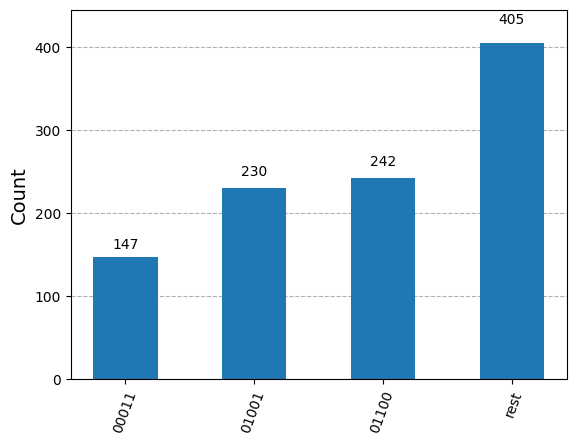

In [10]:
plot_histogram(count, number_to_keep=3)
plt.show()

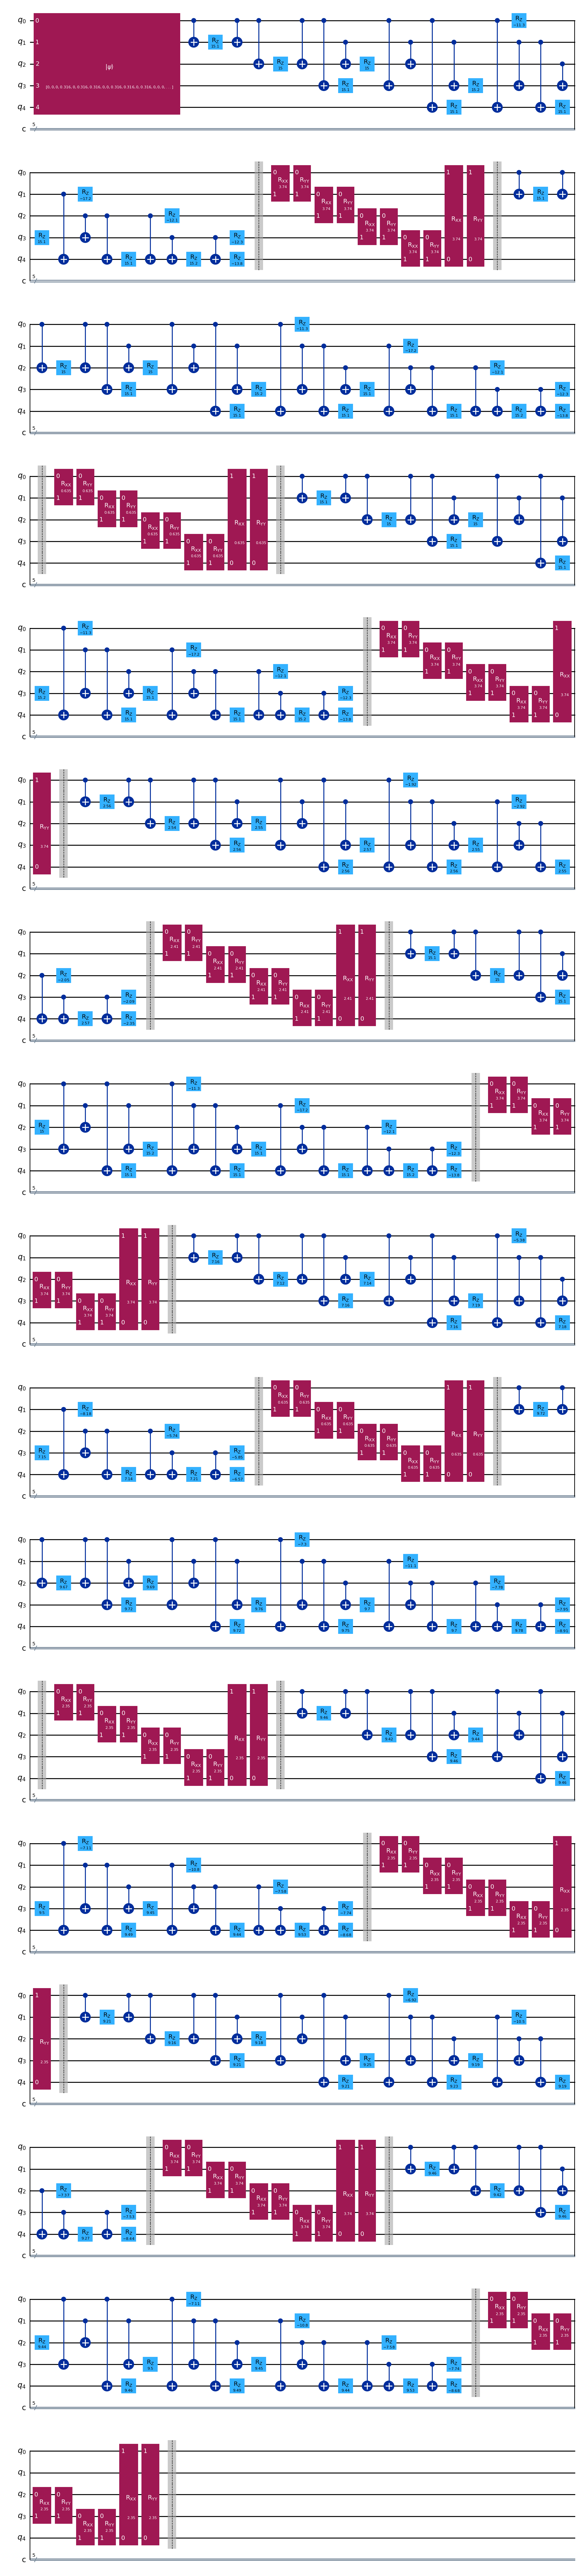

In [11]:
qaoa = QAOA(expected_value, cov_matrix, q, B, lamb, qc=qc_initial_state, mixture_layer='ring_mixer')
for i in range(len(gamma)):
    qaoa.add_layer(gamma[i], beta[i])
qaoa.draw()